### Download Aerosol Data
---

In [84]:
import requests

# Dropbox file download link
url = "https://www.dropbox.com/scl/fi/7e5gawmd22ns2nqhc79v4/PartMC.csv?rlkey=3drypyezuwyeq0k1j4gzhmtib&st=j4hdpots&dl=1"

# Target filename to save the downloaded file
file_name = "PartMC.csv"

# Send a GET request to download the file
response = requests.get(url)

# Write the content to a file
with open(file_name, "wb") as file:
    file.write(response.content)

print(f"File has been downloaded and saved as {file_name}")


File has been downloaded and saved as PartMC.csv




### Package Installation
---

In [38]:
!pip install pandas numpy scikit-learn flaml joblib matplotlib seaborn dask[dataframe]

## Tutorial of AutoML for simple emulator development
---

Fei Jiang, Junjie Yu, Zhonghua Zheng, David Topping

The University of Mancherster, Manchester, UK

Language: Python

---

### Summary of workflow
- Mastering FLAML: A Guide to Training Emulators

### Step 1: import the libraries
---

In [76]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GroupShuffleSplit
from scipy.stats import gaussian_kde
from flaml import AutoML
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

- Flaml version: 2.1.2
- XGBoost version: 2.0.3

### Step 2: Load the data
---

#### All data generated from PartMC-MOSAIC model

##### Data Attributes
- Scenario_ID: Case ID of each simulation by PartMC-MOSAIC model
- DayofYear:  The ordinal position of a date within a year, starting from January 1st. January 1st is day 1, and December 31st is day 365 (or day 366 in a leap year).
- Time(hr): A specific point within a day (unit:Hour)  (Each scenario including 24hr simulation time)
---
- O3 (ppb): gas concentration (unit:ppb)
- CO (ppb): gas concentration (unit:ppb)
- NO (ppb): gas concentration (unit:ppb)
- NOx (ppb): gas concentration (unit:ppb)
---
- CH3OH (ppb): VOC gas concentration (unit:ppb)
- C2H6 (ppb): VOC gas concentration (unit:ppb)
- ETH (ppb): Ethylene - VOC gas concentration (unit:ppb)
- TOL (ppb): Toluene - VOC gas concentration (unit:ppb)
- XYL (ppb): Xylene - VOC gas concentration (unit:ppb)
- ALD2 (ppb): Acetaldehyde - VOC gas concentration (unit:ppb)
- AONE (ppb): Acetone - VOC gas concentration (unit:ppb)
- PAR (ppb): Paraffins - VOC gas concentration (unit:ppb)
- OLET (ppb): Olefins - VOC gas concentration (unit:ppb)
---
- Temperature(K)
- RH: Relative Humidity (0-1)
---
- BC (ug/m3): Black Carbon - Aerosol (unit: ug/m³)
- OA (ug/m3): Organic Aerosol - Aerosol (unit: ug/m³)
- NH4 (ug/m3): Ammonium - Aerosol (unit: ug/m³)
- NO3 (ug/m3): Nitrate - Aerosol (unit: ug/m³)
- SO4 (ug/m3): Sulfate - Aerosol (unit: ug/m³)
---
- Chi: Aerosol Mixing State Index ($\chi$) (ranging form 0-1)

---
#### Aerosol Mixing State
A way to account for differences in chemical composition across an aerosol.

---
##### Aerosol Mixing State index ($\chi$)

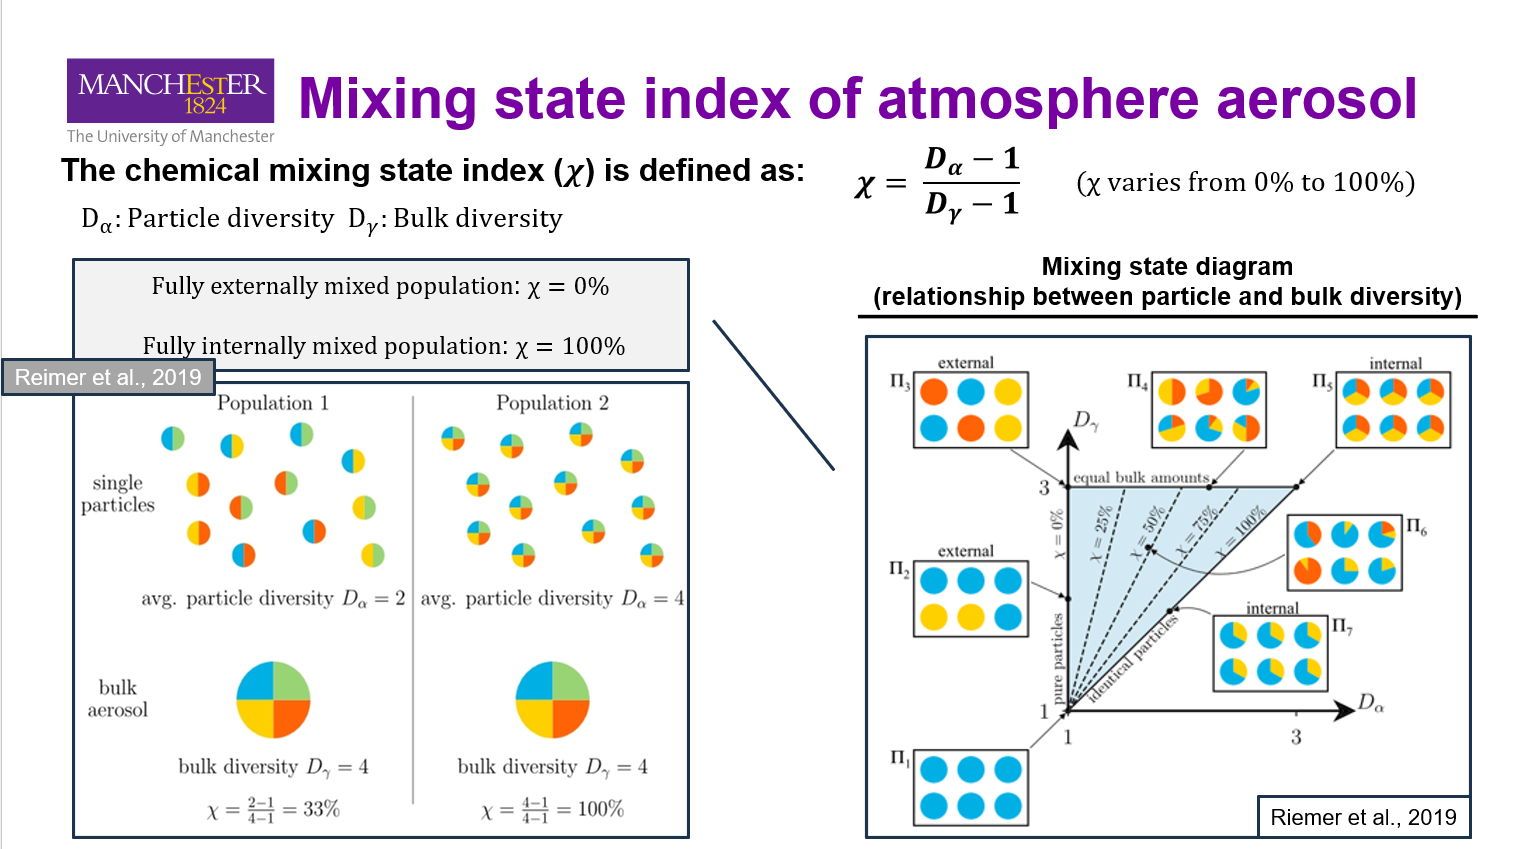

In [85]:
PartMC_data = pd.read_csv('PartMC_data.csv')  # Load the CSV file into a DataFrame called PartMC_data
print('No. of row: {}, no. of columns: {}'.format(PartMC_data.shape[0], PartMC_data.shape[1])) # Print the number of rows and columns in the DataFrame

No. of row: 22500, no. of columns: 24


In [41]:
print(PartMC_data.columns) # Display the column titles of the DataFrame
print('-------------------------------------------------------------------------------------')
print(PartMC_data.head()) # Display the first few rows of the DataFrame along with the column titles


Index(['Scenario_ID', 'DayofYear', 'Time(hr)', 'O3 (ppb)', 'CO (ppb)',
       'NO (ppb)', 'NOx (ppb)', 'CH3OH (ppb)', 'C2H6 (ppb)', 'ETH (ppb)',
       'TOL(ppb)', 'XYL (ppb)', 'ALD2 (ppb)', 'AONE (ppb)', 'PAR (ppb)',
       'OLET (ppb)', 'Temperature(K)', 'RH', 'BC (ug/m3)', 'OA (ug/m3)',
       'NH4 (ug/m3)', 'NO3 (ug/m3)', 'SO4 (ug/m3)', 'Chi'],
      dtype='object')
-------------------------------------------------------------------------------------
   Scenario_ID  DayofYear  Time(hr)    O3 (ppb)    CO (ppb)  NO (ppb)  \
0            1        234         0  162.749629  564.065217  0.000020   
1            1        234         1  155.856708  545.475849  0.000020   
2            1        234         2  149.410138  527.862373  0.000019   
3            1        234         3  143.372736  511.173060  0.000018   
4            1        234         4  137.714718  495.359429  0.000017   

   NOx (ppb)  CH3OH (ppb)  C2H6 (ppb)  ETH (ppb)  ...  PAR (ppb)  OLET (ppb)  \
0   1.915543     0.851

In [62]:
# Calculate the number of missing (null) values in each column of the DataFrame
missing_values = PartMC_data.isnull().sum()

# Print the result, which shows the number of missing values for each column
print(missing_values)

Scenario_ID       0
DayofYear         0
Time(hr)          0
O3 (ppb)          0
CO (ppb)          0
NO (ppb)          0
NOx (ppb)         0
CH3OH (ppb)       0
C2H6 (ppb)        0
ETH (ppb)         0
TOL(ppb)          0
XYL (ppb)         0
ALD2 (ppb)        0
AONE (ppb)        0
PAR (ppb)         0
OLET (ppb)        0
Temperature(K)    0
RH                0
BC (ug/m3)        0
OA (ug/m3)        0
NH4 (ug/m3)       0
NO3 (ug/m3)       0
SO4 (ug/m3)       0
Chi               0
dtype: int64


### Step 3: Data split into training and testing set
---

##### We have 1,000 independent scenarios, each containing 24 hours of time-series data.

Q: How should we fairly split the training and testing sets? Should it be done randomly or using a time-series split?

A: To fairly split the training and testing sets, especially when working with grouped data such as scenarios, it is advisable to use a method that respects the groupings, ensuring that entire groups are either in the training set or the testing set, but not split between them.


#### Task: Dataset Splitting with Group Integrity
Write a code snippet to split the dataset PartMC_data based on the group information provided in the Scenario_ID column. Ensure that the same group does not appear in both the training and testing sets. Assign 70% of the data to the training set and 30% to the testing set.

**Requirements:**

- Use GroupShuffleSplit to perform the split.
- Ensure that the testing set contains 30% of the data.
- Maintain group integrity during the split (i.e., data points with the same Scenario_ID should not be split between the training and testing sets).
- Set random_state (such as random_state=42) to ensure the split is reproducible.
- Output the training and testing datasets after the split.



In [63]:
# Split the dataset based on scenario groups - 70% training set & 30% testing set
splitter = GroupShuffleSplit(test_size=0.1, n_splits=1, random_state=42)
train_idxs, test_idxs = next(splitter.split(PartMC_data, groups=PartMC_data['Scenario_ID']))

# Create train and test datasets
train, test = PartMC_data.iloc[train_idxs], PartMC_data.iloc[test_idxs]

print("Training Set:")
print(train)
print("\nTesting Set:")
print(test)

Training Set:
       Scenario_ID  DayofYear  Time(hr)    O3 (ppb)    CO (ppb)  NO (ppb)  \
0                1        234         0  162.749629  564.065217  0.000020   
1                1        234         1  155.856708  545.475849  0.000020   
2                1        234         2  149.410138  527.862373  0.000019   
3                1        234         3  143.372736  511.173060  0.000018   
4                1        234         4  137.714718  495.359429  0.000017   
...            ...        ...       ...         ...         ...       ...   
24995         1000        205        20  106.914318  314.335501  0.211579   
24996         1000        205        21  108.907729  308.524698  0.180998   
24997         1000        205        22  110.118135  302.708175  0.154614   
24998         1000        205        23  110.537684  297.035474  0.136611   
24999         1000        205        24  110.319420  291.672368  0.124570   

       NOx (ppb)  CH3OH (ppb)  C2H6 (ppb)  ETH (ppb)  ...  PA

---
##### To check if each scenario is fully assigned to either the training or testing set without being split between them
---

In [ ]:
# Extract the Scenario_ID column from both datasets
train_ids = set(train['Scenario_ID'])
test_ids = set(test['Scenario_ID'])

# Find any Scenario_IDs that appear in both training and testing sets
overlap_ids = train_ids.intersection(test_ids)

# Check if any Scenario_IDs are split between the training and testing sets
if overlap_ids:
    print("Error: The following Scenario_IDs are found in both training and testing sets:", overlap_ids)
else:
    print("Success: No Scenario_IDs are split between training and testing sets.")

Success: No Scenario_IDs are split between training and testing sets.


### Step 4: Feature data distribution of training and testing set
---

In data analysis, it's often useful to compare the distributions of features between training and testing sets. This helps ensure that the training and testing sets are similar and that the model can generalize well from the training set to the testing set. In this exercise, you'll use "matplotlib" and "seaborn" to plot the distribution of selected features from both the training and testing datasets.

---

Index(['O3 (ppb)', 'CO (ppb)', 'NO (ppb)', 'NOx (ppb)', 'CH3OH (ppb)',
       'C2H6 (ppb)', 'ETH (ppb)', 'TOL(ppb)', 'XYL (ppb)', 'ALD2 (ppb)',
       'AONE (ppb)', 'PAR (ppb)', 'OLET (ppb)', 'Temperature(K)', 'RH',
       'BC (ug/m3)', 'OA (ug/m3)', 'NH4 (ug/m3)', 'NO3 (ug/m3)', 'SO4 (ug/m3)',
       'Chi'],
      dtype='object')


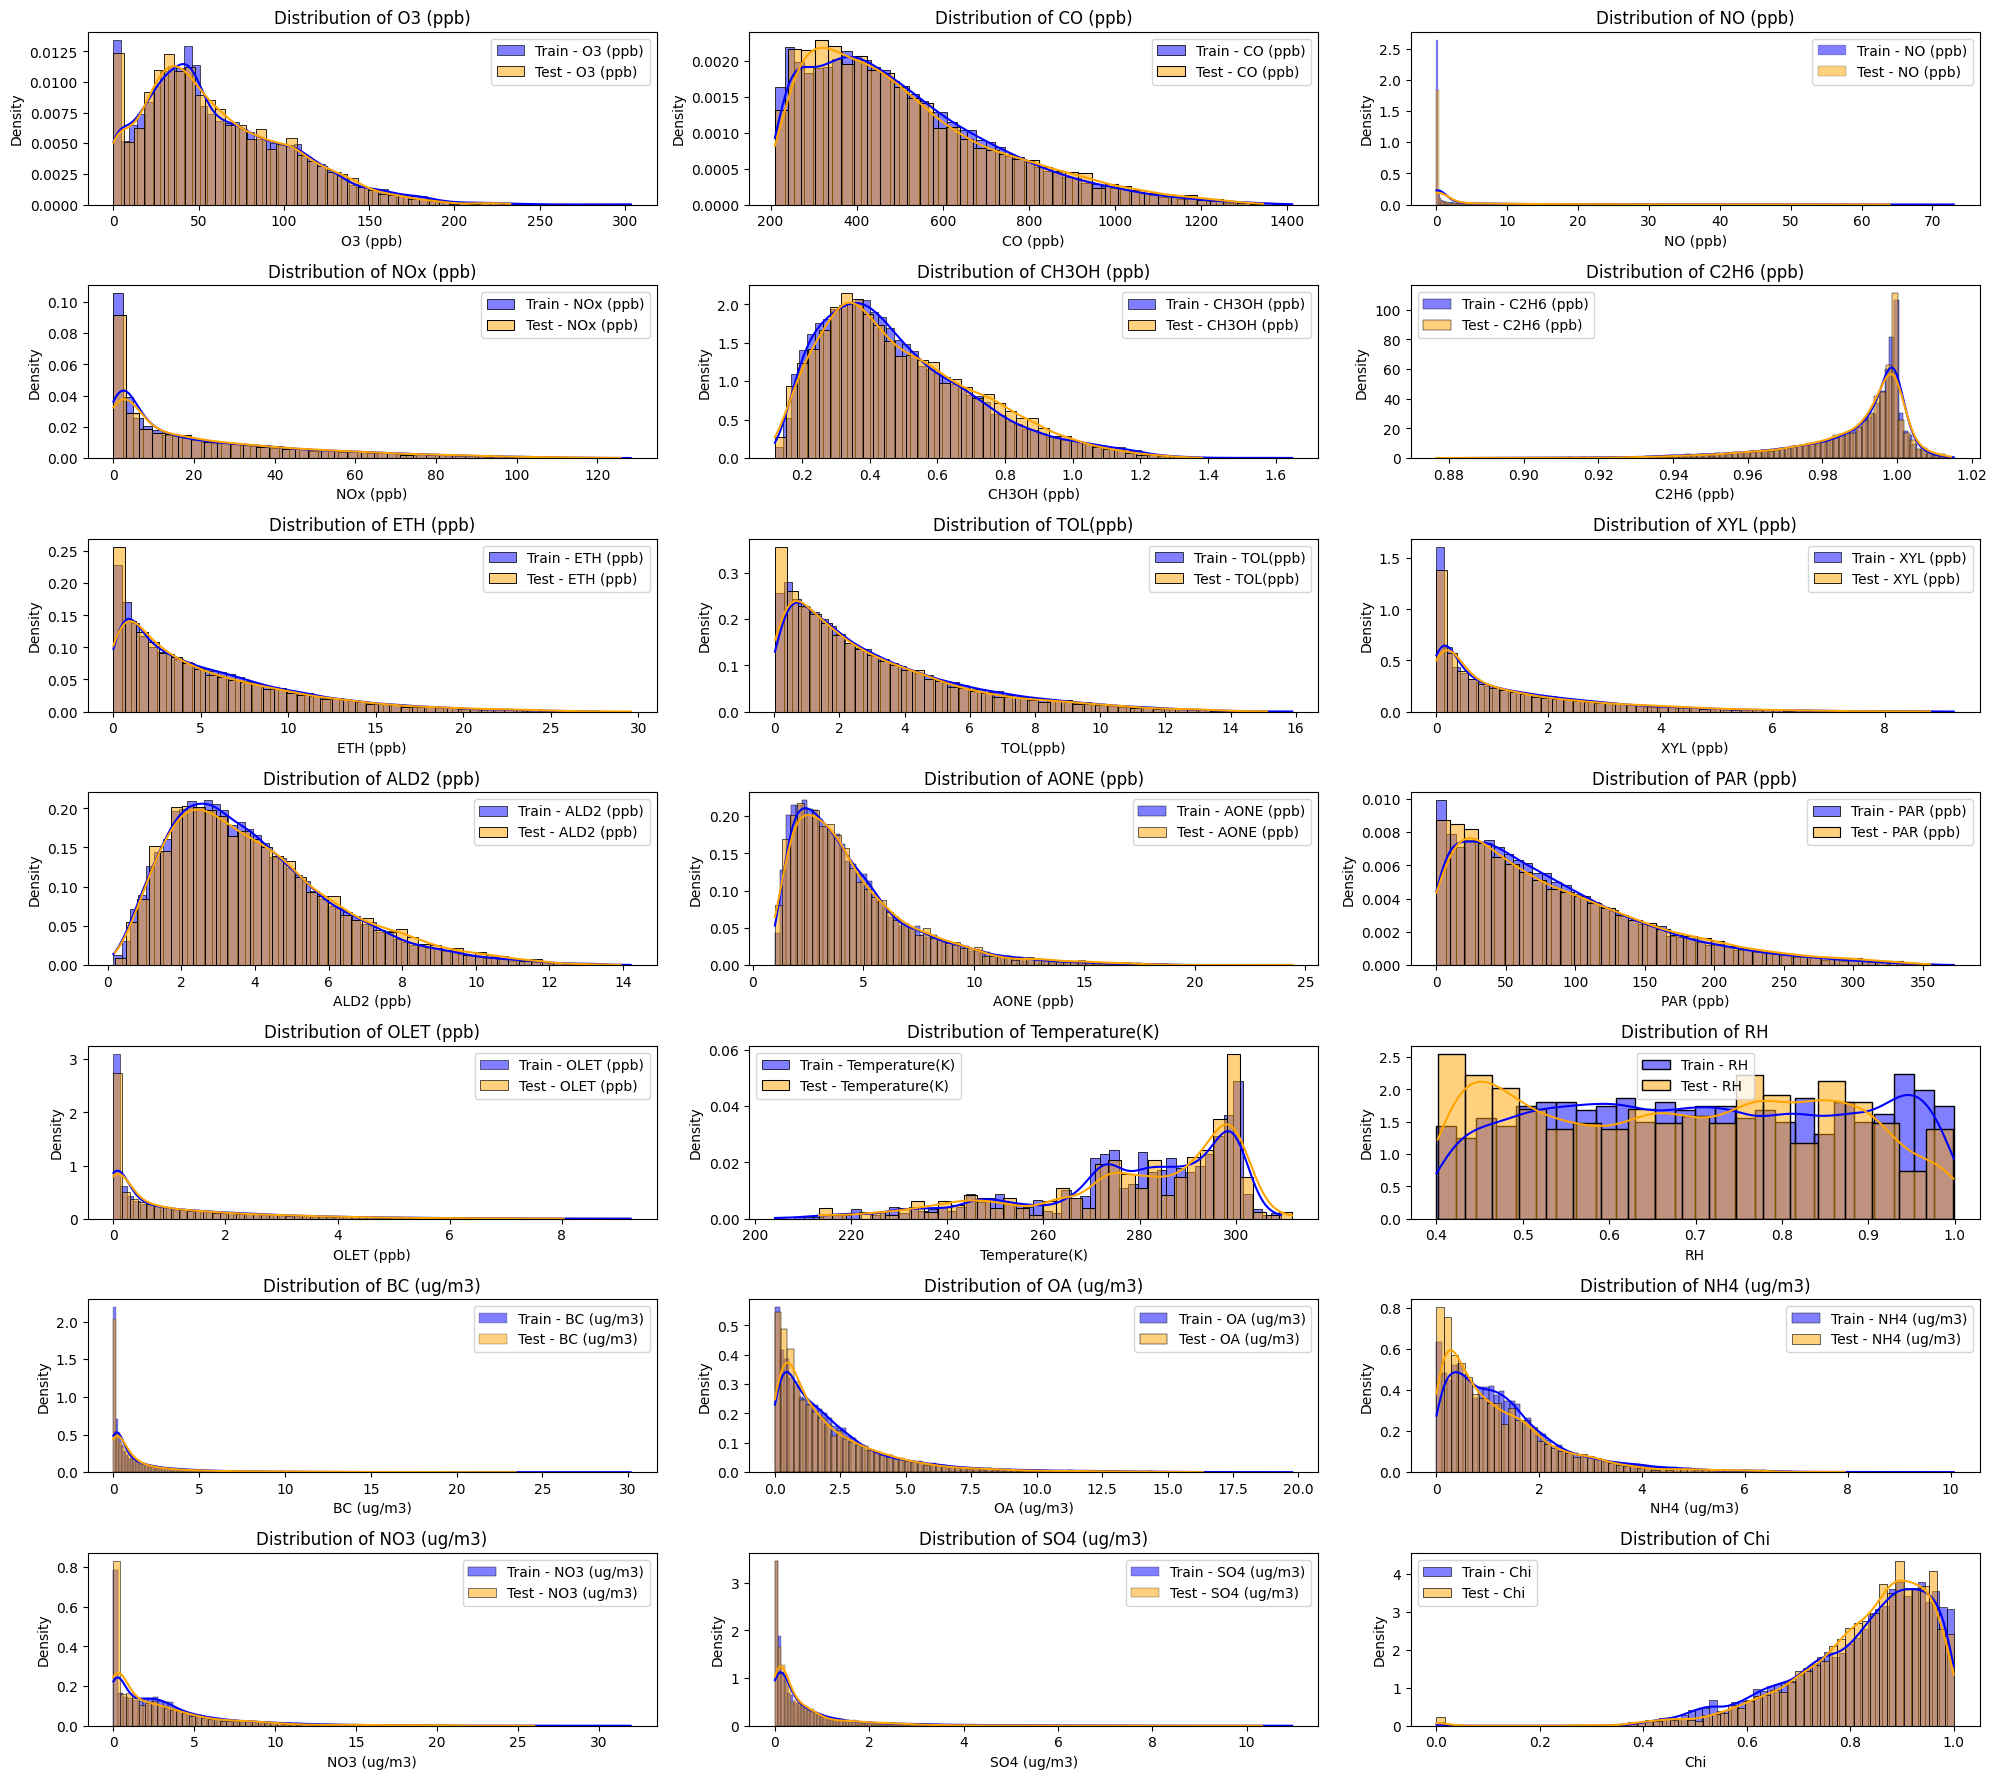

In [44]:
# Select all features except the first three
features_to_plot = train.columns[3:]
print(features_to_plot)
# Set up the matplotlib figure
plt.figure(figsize=(20, 20))

# Plot the distribution for each selected feature
for i, feature in enumerate(features_to_plot):
    plt.subplot(len(features_to_plot) // 3 + 1, 3, i + 1)
    sns.histplot(train[feature], kde=True, color='blue', label=f'Train - {feature}', stat='density', common_norm=False, alpha=0.5)
    sns.histplot(test[feature], kde=True, color='orange', label=f'Test - {feature}', stat='density', common_norm=False, alpha=0.5)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Density')
    plt.legend()

plt.tight_layout()
plt.show()

### Step 5: Developing an emulator
---
##### Regression task
---
Problem Definition - Define X and y

In [51]:
input_list = ['O3 (ppb)', 'CO (ppb)', 'NO (ppb)', 'NOx (ppb)', 'CH3OH (ppb)',
        'C2H6 (ppb)', 'ETH (ppb)', 'TOL(ppb)', 'XYL (ppb)', 'ALD2 (ppb)',
       'AONE (ppb)', 'PAR (ppb)', 'OLET (ppb)', 'Temperature(K)', 'RH',
       'BC (ug/m3)', 'OA (ug/m3)', 'NH4 (ug/m3)', 'NO3 (ug/m3)', 'SO4 (ug/m3)']

log_file_name = "AutoML_emulator"+".log"
model_file_name = "AutoML_emulator" + ".pkl"
output_file = "AutoML_emulator"+".csv"

output_list = ['Chi'] # feature - aerosol mixing state index (Chi)
X_train = train[input_list]
y_train = train[output_list].squeeze()

# Extract the features and true target values from the test set
X_test = test[input_list]
y_test = test[output_list].squeeze()  # Ensure y_test is a Series

---
- Mertic for model performance on testing dataset - (R$^2$, RMSE, MAE)
- Plot figure - y_true vs y_pred
---


\begin{equation}
    \text{MSE} = \frac{1}{n} \sum_{i=1}^n (y_i - \hat{y}_i)^2,
\end{equation}

\begin{equation}
    \text{RMSE} = \sqrt{\text{MSE}} = \sqrt{\frac{1}{n} \sum_{i=1}^n (y_i - \hat{y}_i)^2},
\end{equation}

\begin{equation}
    \text{MAE} = \frac{1}{n} \sum_{i=1}^n |y_i - \hat{y}_i|,
\end{equation}

\begin{equation}
    \text{R2} = 1 - \frac{\sum_{i=1}^n (y_i - \hat{y}_i)^2}{\sum_{i=1}^n (y_i - \bar{y_m})^2},
\end{equation}

where $y_i$ and $y{\hat{}}_i$ are the observations and model predictions, respectively; n is the number of samples; $y_m$ is the mean of the observations.

In [54]:
# Assume we have true values and predicted values
import numpy as np
y_true = np.array([3.0, -0.5, 2.0, 7.0])  # True values
y_pred = np.array([2.5, 0.0, 2.1, 7.8])   # Predicted values

# Calculate MSE (Mean Squared Error)
mse = np.mean((y_true - y_pred) ** 2)
print(f'MSE: {mse}')

# Calculate RMSE (Root Mean Squared Error)
rmse = np.sqrt(mse)
print(f'RMSE: {rmse}')

# Calculate R² (R-squared)
r2 = 1 - mse/np.mean((y_true - np.mean(y_true)) ** 2)
print(f'R²: {r2}')

# Calculate MAE (Mean Absolute Error)
mae = np.mean(np.abs(y_true - y_pred))
print(f'MAE: {mae}')

MSE: 0.2874999999999999
RMSE: 0.5361902647381803
R²: 0.9605995717344754
MAE: 0.475


In [49]:
def calculate_metrics_and_plot(y_true, y_pred):
    # Calculate R2, RMSE, MAE
    mse = np.mean((y_true - y_pred) ** 2)
    rmse = np.sqrt(mse)
    r2 = 1 - mse/np.mean((y_true - np.mean(y_true)) ** 2)
    mae = np.mean(np.abs(y_true - y_pred))

    # Print the calculated metrics
    print(f'R2: {r2}')
    print(f'RMSE: {rmse}')
    print(f'MAE: {mae}')

    # Calculate point density
    xy = np.vstack([y_true, y_pred])
    z = gaussian_kde(xy)(xy)

    # Plot y_true vs y_pred density scatter plot
    plt.figure(figsize=(8, 7))

    scatter = plt.scatter(y_true, y_pred, c=z, s=20, cmap='rainbow')

    # Create color bar
    cbar = plt.colorbar(scatter)
    cbar.set_label('Density', fontsize=17)  # Set the color bar label and fontsize
    cbar.ax.tick_params(labelsize=16)  # Set the font size for the color bar ticks

    # Plot a reference line (ideal prediction line y_true = y_pred)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.xlabel('Mixing State Index $\chi$', fontsize=17)
    plt.ylabel('Predicted Mixing State Index $\chi$', fontsize=17)
    plt.tick_params(axis='both', which='major', direction='in', length=6, width=2, colors='black',
                    grid_color='gray', grid_alpha=0.7, labelsize=16)

    # Annotate with the metrics in the top left corner
    metrics_text = f'R$^2$: {r2:.4f}\nRMSE: {rmse:.4f}\nMAE: {mae:.4f}'
    plt.text(0.05, 0.95, metrics_text, transform=plt.gca().transAxes,
             fontsize=14,  # Adjust the font size
             verticalalignment='top', horizontalalignment='left',
             bbox=dict(facecolor='white', alpha=0.7, edgecolor='black', boxstyle='round,pad=0.5'))

    plt.title('Actual vs Predicted Scatter Plot with Density', fontsize=15)
    plt.grid(True)
    plt.show()

---
#### Train emulator by XGBoost
To enhance model performance, you can fine-tune hyperparameters such as n_estimators, learning_rate, and max_depth:

- n_estimators: This parameter defines the number of trees in your ensemble model. Increasing it can improve performance but may lead to overfitting.

- learning_rate: This controls the contribution of each tree to the final model. A lower learning rate makes the model more robust to overfitting, but it may require more trees to reach optimal performance.

- max_depth: This determines the maximum depth of each tree in the model. A deeper tree can capture more complex patterns but might overfit the training data.

By carefully tuning these parameters, you can significantly improve your model's performance.
---

[0]	validation_0-rmse:0.13476	validation_1-rmse:0.13230
[1]	validation_0-rmse:0.13401	validation_1-rmse:0.13166
[2]	validation_0-rmse:0.13325	validation_1-rmse:0.13106
[3]	validation_0-rmse:0.13251	validation_1-rmse:0.13044
[4]	validation_0-rmse:0.13179	validation_1-rmse:0.12986
[5]	validation_0-rmse:0.13105	validation_1-rmse:0.12926
[6]	validation_0-rmse:0.13034	validation_1-rmse:0.12871
[7]	validation_0-rmse:0.12962	validation_1-rmse:0.12812
[8]	validation_0-rmse:0.12893	validation_1-rmse:0.12757
[9]	validation_0-rmse:0.12824	validation_1-rmse:0.12701
[10]	validation_0-rmse:0.12756	validation_1-rmse:0.12647
[11]	validation_0-rmse:0.12689	validation_1-rmse:0.12591
[12]	validation_0-rmse:0.12622	validation_1-rmse:0.12541
[13]	validation_0-rmse:0.12557	validation_1-rmse:0.12486
[14]	validation_0-rmse:0.12492	validation_1-rmse:0.12436
[15]	validation_0-rmse:0.12428	validation_1-rmse:0.12383
[16]	validation_0-rmse:0.12366	validation_1-rmse:0.12333
[17]	validation_0-rmse:0.12303	validation

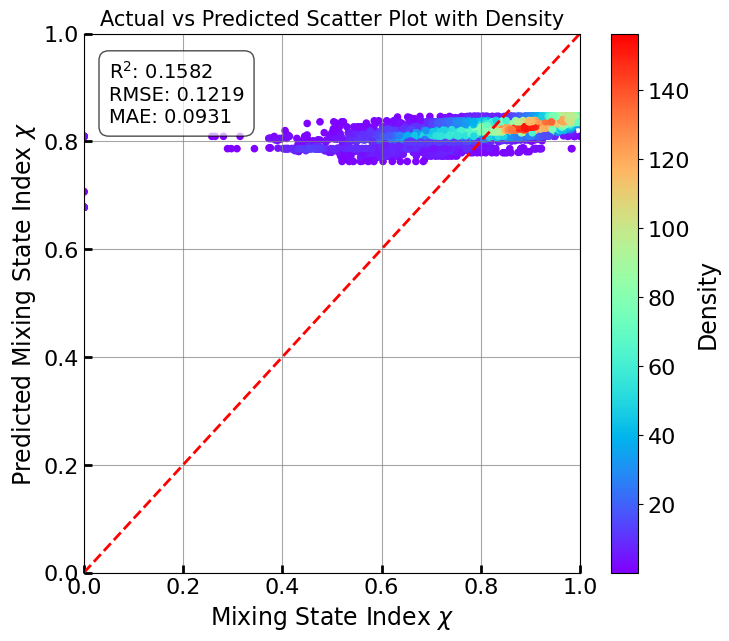

In [52]:
# Create an XGBoost regression model with evaluation metrics included in the parameters
# Explanation of parameters:
# - objective: Set to 'reg:squarederror', indicating that this is a regression problem using squared error as the loss function.
# - n_estimators: The number of trees to be built, which determines the number of iterations in the model. Here it's set to 20.
# - learning_rate: The learning rate, which controls the contribution of each tree to the model. Here it's set to 0.01.
# - max_depth: The maximum depth of each tree, which helps prevent overfitting. Here it's set to 5.
# - eval_metric: The evaluation metric, set to 'rmse' (Root Mean Squared Error) to evaluate the model's performance during training.
# - random_state: The random seed, set to 42 to ensure reproducibility of results.
model = xgb.XGBRegressor(objective='reg:squarederror',
              n_estimators=20 ,
              learning_rate=0.01 ,
              max_depth=5 ,
              eval_metric="rmse",
              random_state=42 )

# Define the evaluation set (used to evaluate model performance during training)
# The evaluation set is typically used to monitor model performance during training.
# Here, both the training set and the test set are used for evaluation.
# - X_train, y_train: The training data and corresponding target values.
# - X_test, y_test: The test data and corresponding target values.
eval_set = [(X_train, y_train), (X_test, y_test)]

# Train the model with verbose output
# - The fit method is used to train the model.
# - The eval_set parameter provides datasets for model evaluation. The model will evaluate performance on these datasets and output the evaluation metric values for each iteration.
# - verbose=True ensures that detailed log information is printed during training, which helps you track the progress.
model.fit(X_train, y_train, eval_set=eval_set, verbose=True)

# Predict the target variable for the test set
# - The predict method generates predictions, and y_test_pred contains the model's predictions for the test data X_test.
y_test_pred = model.predict(X_test)

# Calculate metrics and plot the results
# - The calculate_metrics_and_plot function (assumed to be defined earlier) is used to calculate common regression evaluation metrics (e.g., MSE, RMSE, R², MAE) and plot relevant results.
calculate_metrics_and_plot(y_test, y_test_pred)

---
#### Train model by Flaml
---
##### Introduction
- FLAML (Fast and Lightweight AutoML) is a lightweight AutoML library designed for quick, cost-effective model training and hyperparameter tuning. Compared to traditional manual tuning methods, FLAML automates the selection of the best model and parameter configurations, speeding up the model development process while significantly reducing computational resources without sacrificing accuracy. Training models with FLAML is particularly suitable for applications requiring rapid iterations, such as time-sensitive prediction tasks.

##### Comparison with XGBoost:
- XGBoost is a decision-tree-based gradient boosting algorithm widely recognized for its efficiency and ability to handle complex data. However, XGBoost typically requires manual hyperparameter tuning to achieve optimal performance, which can be challenging for users. In contrast, FLAML automates model selection and hyperparameter optimization, reducing the tuning burden on users while still utilizing XGBoost as one of its underlying algorithms, providing an efficient model training solution.

---

In [53]:
# Initialize the AutoML instance
automl = AutoML(random_state=42)
n_jobs = 8
# Define the time budget for the AutoML process (in seconds)
time_budget = 20

# Define the settings for the AutoML process
automl_settings = {
    "time_budget": time_budget,  # Maximum time allowed for the AutoML process
    "metric": 'mse',  # Metric used to evaluate the models ('mse' for regression)
    "task": 'regression',  # Specify the type of task ('regression' in this case)
    "eval_method": "cv",  # Evaluation method ('cv' stands for cross-validation)
    "n_splits": 5,  # Number of splits for cross-validation
    "estimator_list": [  # List of models to consider
        "lgbm",       # LightGBM
        "xgboost",    # XGBoost
        "rf",         # Random Forest
        "extra_tree", # Extra Trees
        # "catboost",  # Uncomment to include CatBoost
        # "ann",       # Uncomment to include Artificial Neural Networks
        # "svr",       # Uncomment to include Support Vector Regression
    ],
    "n_jobs": n_jobs,  # Number of jobs to run in parallel (-1 uses all available cores)
    "log_file_name": log_file_name,  # Name of the log file to store AutoML logs
}

# Train the AutoML model with the provided training data
automl.fit(X_train=X_train, y_train=y_train, **automl_settings)

# Print the best estimator selected by AutoML
print(automl.model.estimator)

# Save the best model selected by AutoML to a file
best_model = automl.model.estimator
joblib.dump(best_model, model_file_name)

[flaml.automl.logger: 08-19 23:18:09] {1680} INFO - task = regression
[flaml.automl.logger: 08-19 23:18:09] {1691} INFO - Evaluation method: cv
[flaml.automl.logger: 08-19 23:18:09] {1789} INFO - Minimizing error metric: mse
[flaml.automl.logger: 08-19 23:18:09] {1901} INFO - List of ML learners in AutoML Run: ['lgbm', 'xgboost', 'rf', 'extra_tree']
[flaml.automl.logger: 08-19 23:18:09] {2219} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 08-19 23:18:09] {2345} INFO - Estimated sufficient time budget=4651s. Estimated necessary time budget=5s.
[flaml.automl.logger: 08-19 23:18:09] {2392} INFO -  at 0.6s,	estimator lgbm's best error=0.0155,	best estimator lgbm's best error=0.0155
[flaml.automl.logger: 08-19 23:18:10] {2219} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 08-19 23:18:10] {2392} INFO -  at 1.1s,	estimator lgbm's best error=0.0155,	best estimator lgbm's best error=0.0155
[flaml.automl.logger: 08-19 23:18:10] {2219} INFO - iteration 2, current

['AutoML_emulator.pkl']

###### Emulator performance on testing dataset

R2: 0.7356560883187269
RMSE: 0.06829485489586364
MAE: 0.050625574080072615


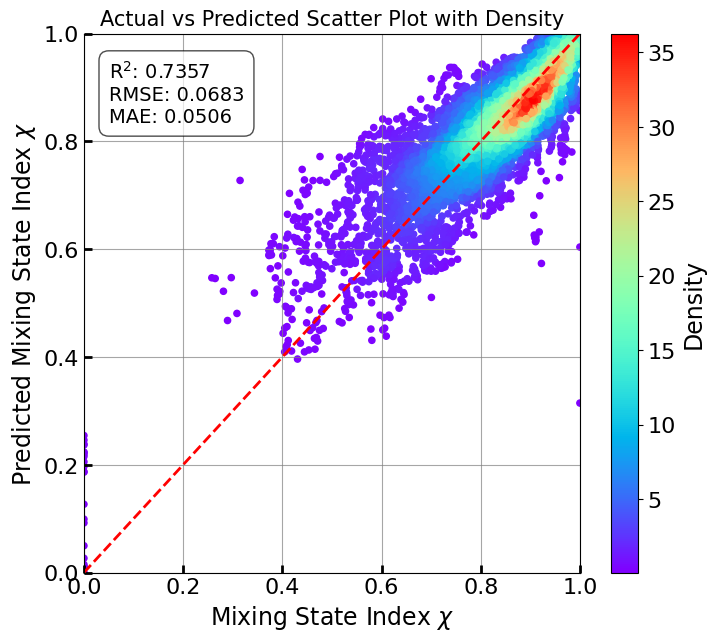

In [ ]:
# Load the trained model using joblib
automl = joblib.load(model_file_name)

# Extract the features and true target values from the test set
X_test = test[input_list]
y_test = test[output_list].squeeze()  # Ensure y_test is a Series

# Make predictions using the trained model
y_test_pred = automl.predict(X_test)

# Calculate metrics and plot the density scatter plot
calculate_metrics_and_plot(y_test, y_test_pred)



---
#### Task: Train the Best Emulator using XGBoost or FLAML - **Get your first data dirven model!!!!**

**Background:**

In machine learning, an emulator is often used to replace computationally intensive physical models by learning from data to quickly predict the behavior of complex systems. XGBoost is a widely used gradient boosting algorithm known for its efficiency and accuracy. FLAML (Fast and Lightweight AutoML) is an automated machine learning library that aims to simplify the model training process by quickly finding high-performing models and hyperparameters.

---

**Objective:**

- Train a high-performance emulator model using either XGBoost or FLAML.
- Compare the models' performance and select the best one.
- Use the selected model to make predictions on new data.

---

In [90]:
import requests

# Dropbox file download link
url = "https://www.dropbox.com/scl/fi/2on5tc8y7c31jz9kfltli/PartMC_Target.csv?rlkey=nb877x9jhr4rd23ukli77k86b&st=lc4p45tw&dl=1"

# Target filename to save the downloaded file
file_name = "PartMC_Target.csv"

# Send a GET request to download the file
response = requests.get(url)

# Write the content to a file
with open(file_name, "wb") as file:
    file.write(response.content)

print(f"File has been downloaded and saved as {file_name}")


File has been downloaded and saved as PartMC_Target.csv


In [91]:
PartMC_data = pd.read_csv('PartMC_Target.csv')  # Load the CSV file into a DataFrame called PartMC_data
print('No. of row: {}, no. of columns: {}'.format(PartMC_data.shape[0], PartMC_data.shape[1])) # Print the number of rows and columns in the DataFrame

No. of row: 2500, no. of columns: 24


#### **Thinking**

**Are the 20 Features We've Selected All Important to the Model? How Important Are They? How Do We Filter Meaningful Features? What Methods Can We Use?**
